In [2]:
# Import the modules
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
% matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

/home/rupamay/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
UsageError: Line magic function `%` not found.


In [3]:
#Load data into a pandas dataframe here
df = pd.read_csv("Combined_Pond2_val_set.csv",delimiter=',',low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True) 

In [4]:
df.isnull().sum()

Datetime            0
Temperature         0
Turbidity           0
Dissolved Oxygen    0
PH                  0
Ammonia             0
Nitrate             0
Population          0
Fish_Length         0
Fish_Weight         0
Weight_diff         0
dtype: int64

In [5]:
df.head(5)

,Datetime,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Population,Fish_Length,Fish_Weight,Weight_diff
0,2021-07-31 21:07:00,24.8750,6.0,38.702,7.29424,0.56720,719.0,50.0,17.75,46.5,0.0
1,2021-07-31 21:08:00,24.9375,6.0,38.694,7.29424,0.57584,717.0,50.0,17.75,46.5,0.0
2,2021-07-31 21:09:00,24.9375,6.0,38.677,7.30332,0.56935,719.0,50.0,17.75,46.5,0.0
3,2021-07-31 21:10:00,24.8750,6.0,38.652,7.29424,0.56720,720.0,50.0,17.75,46.5,0.0
4,2021-07-31 21:11:00,24.9375,6.0,38.855,7.30332,0.53795,720.0,50.0,17.75,46.5,0.0


In [6]:
X_test = df[['Temperature', 'Turbidity', 'Dissolved Oxygen', 'PH', 'Ammonia','Nitrate']]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_norm = scaler.transform(X_test)


In [8]:
# we'll start out with a 5 minute input sequence and a one day predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 5
ph = 1
num_rows=df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_rows-seq_length-ph):
    seq_arrays.append(X_test_norm[start:start+seq_length])
    seq_labs.append([df['Weight_diff'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [9]:
print(seq_arrays.shape, seq_labs.shape)

(15431, 5, 6) (15431, 1)


# Reloading the model

In [10]:
# define the path to the h5 file containing the saved model
model_path = 'Weight_CNN_LSTM_model5.h5'

# load the model from the h5 file
model = tf.keras.models.load_model(model_path)

In [11]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 5, 32)             416       
                                                                 
 batch_normalization_36 (Bat  (None, 5, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 5, 32)             0         
                                                                 
 conv1d_37 (Conv1D)          (None, 5, 48)             3120      
                                                                 
 batch_normalization_37 (Bat  (None, 5, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 5, 48)           

483/483 - 1s - loss: 0.0223 - mse: 0.0223 - 1s/epoch - 2ms/step

MSE: 0.022314583882689476
483/483 [==============================] - 1s 2ms/step


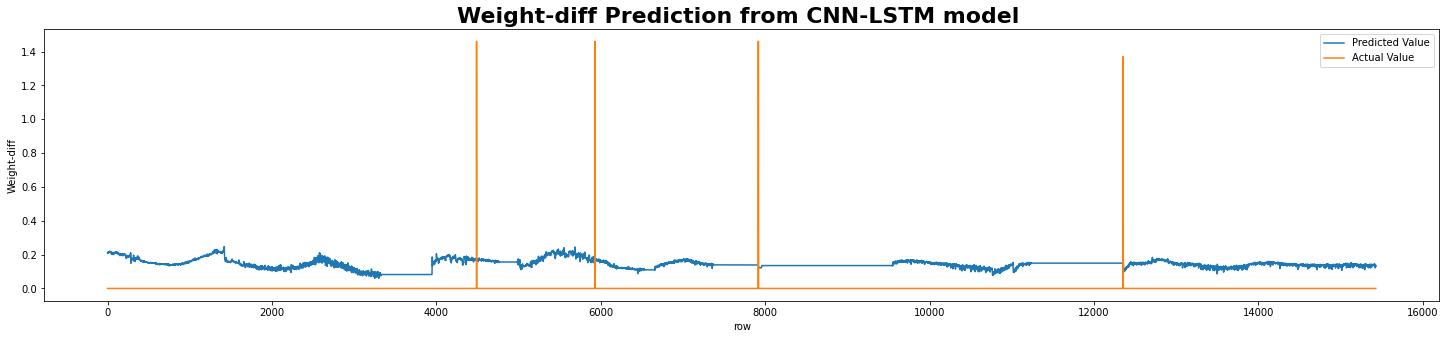

In [12]:
scores_test = model.evaluate(seq_arrays, seq_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(seq_arrays)
y_true_test = seq_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('Weight-diff_predictions_Pond2_from CNN_LSTM_today.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Weight-diff Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Weight-diff')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("Weight-diff_Predictions_Pond2.png")

Last 24 hours

483/483 - 1s - loss: 0.0223 - mse: 0.0223 - 648ms/epoch - 1ms/step

MSE: 0.022314583882689476
483/483 [==============================] - 1s 2ms/step


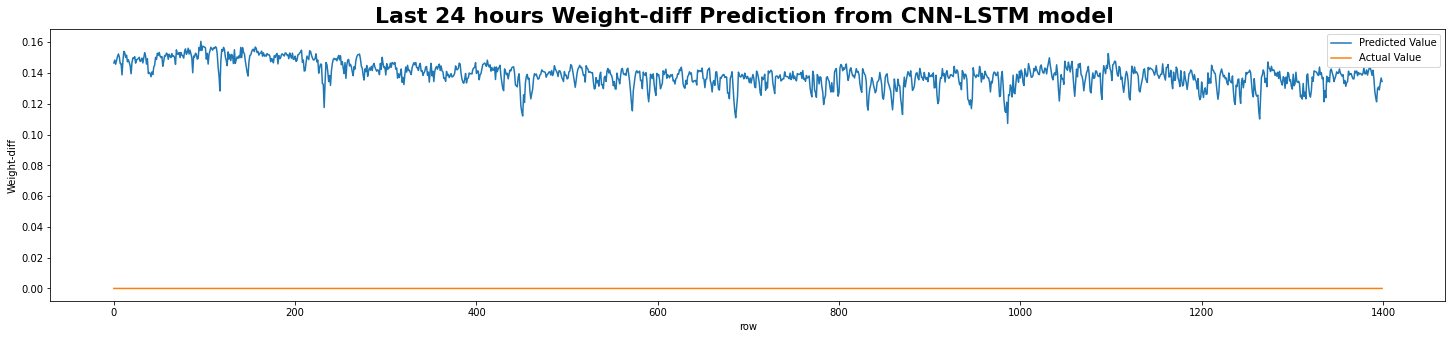

In [13]:
scores_test = model.evaluate(seq_arrays, seq_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(seq_arrays)
y_true_test = seq_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('Weight-diff_predictions_Pond2_from CNN_LSTM_today.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test[-1400:], label = 'Predicted Value')
plt.plot(y_true_test[-1400:], label = 'Actual Value')

plt.title('Last 24 hours Weight-diff Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Weight-diff')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("Weight-diff_Predictions_Pond2.png")

In [14]:
y_true_test

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [15]:
y_pred_test

array([[0.20887671],
       [0.21199848],
       [0.20946497],
       ...,
       [0.13334364],
       [0.13676453],
       [0.13447946]], dtype=float32)

In [28]:
import pickle as pkl
with open('saved_model.pkl', 'rb') as f:
    model = pkl.load(f)